In [1]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')
plt.rcParams.update({'font.size': 14})

INFO: Using numpy backend


In [2]:
_ = plt.plot(cond_var_t)

NameError: name 'cond_var_t' is not defined

In [3]:
min_sigma = 0.1
max_sigma = 1.5
sigma_t = np.log(ts * np.exp(max_sigma) + (1 - ts) * np.exp(min_sigma))
# sigma_t = min_sigma + (max_sigma - min_sigma)*ts
# sigma_t = 10** (ts * np.log10(max_sigma) + (1 - ts) * np.log10(min_sigma))

NameError: name 'ts' is not defined

In [4]:
_ = plt.plot(sigma_t**2 - sigma_t[0]**2)

NameError: name 'sigma_t' is not defined

In [5]:
# Translations
min_b = 0.1
max_b = 20.0
ts = np.linspace(0, 1, 500)
beta_t = ts*min_b + (1/2)*(ts**2)*(max_b-min_b)
cond_var_t = 1 - np.exp(-beta_t)

# Rotations
min_sigma = 0.1
max_sigma = 1.5
def get_rot_sigma(mode):
    if mode == 'logarithmic':
        sigma_t = np.log(ts * np.exp(max_sigma) + (1 - ts) * np.exp(min_sigma))
    elif mode == 'linear':
        sigma_t = min_sigma + (max_sigma - min_sigma)*ts
    return sigma_t**2 - sigma_t[0]**2

# def get_rot_cond_var(t):



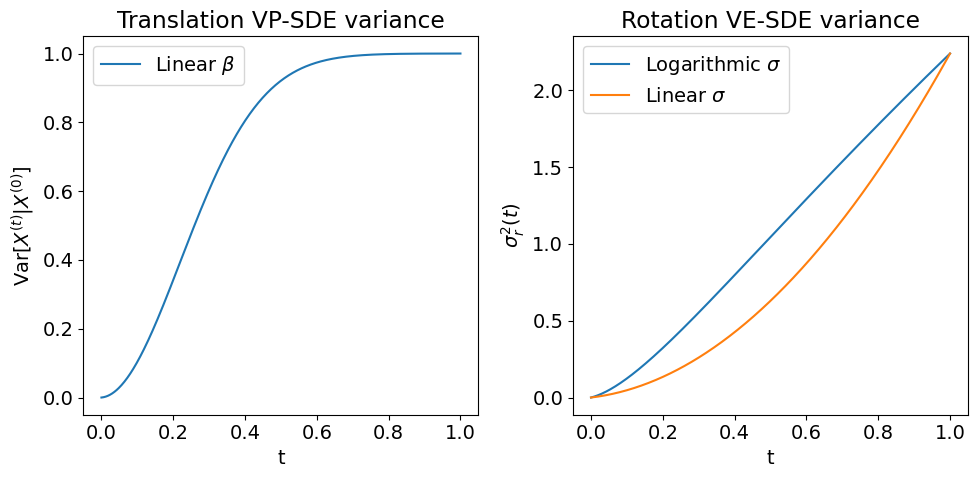

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# fig.suptitle('Variance schedules')
ax1.plot(ts, cond_var_t, label=r'Linear $\beta$')
ax1.set_title('Translation VP-SDE variance')
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\mathrm{Var}[X^{(t)}|X^{(0)}]$')
ax1.legend()

ax2.plot(ts, get_rot_sigma('logarithmic'), label=r'Logarithmic $\sigma$')
ax2.plot(ts, get_rot_sigma('linear'), label=r'Linear $\sigma$')
ax2.set_title('Rotation VE-SDE variance')
ax2.set_xlabel('t')
# ax2.set_ylabel(r'$\mathrm{Var}[R^{(t)}|R^{(0)}]$')
ax2.set_ylabel(r'$\sigma_r^2(t)$')
ax2.legend()
plt.tight_layout()
plt.savefig('variance_schedule.png')
plt.rcParams.update({'font.size': 14})

In [2]:
# Paths
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_5'
samples_dir = os.path.join(base_dir, 'samples')
sample_cluster_dir = os.path.join(base_dir, 'sample_clustering')
figure_dir = os.path.join(base_dir, 'figures')
train_align_dir = os.path.join(base_dir, 'train_align')
train_pdbs_dir = os.path.join(base_dir, 'training_pdbs')


base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_align_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(train_pdbs_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(sample_cluster_dir, exist_ok=True)



if len(os.listdir(base_dir)):
    print('WARNING: overwriting results!')

In [31]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2'
print(f'Reading samples from {results_dir}')
for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for i,sample_name in enumerate(os.listdir(length_dir)):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            design_csv['length'] = int(sample_length.split('_')[1])
            design_csv['sample_id'] = i
            all_csvs.append(design_csv)
self_conditioned_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2


# Process results

In [32]:
def pick_path(x):
    if x.sample_path is None or x.sample_path == '':
        return x.of_path
    return x.sample_path

length_categories = [
    '60-100', '100-200', '200-300', '300-400', '400-500'
][::-1]
buckets = np.arange(0, 501, 100)

def df_process(raw_df):
    # Process sample path
    df = raw_df.copy()
    df['sample_path'] = df['sample_path'].fillna('')
    df['sample_path'] = df.apply(pick_path, axis=1)
    df['sequence_id'] = df['sample_path'].apply(lambda x: int(os.path.basename(x).replace('.pdb', '').split('_')[1]))
    
    # Separate based on whether MPNNed
    df['header'] = df['header'].fillna('')
    df = df[df['header'].map(lambda x: 'sde_1' not in x)]
    return df

def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
    elif metric == 'tm':
        df = raw_df.sort_values('tm_score', ascending=False)
    else:
        raise ValueError(f'Unrecognized metric: {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()

    # Separate into different length groups
    df['length_group'] = df.length.map(lambda x: length_categories[np.sum(x <= buckets).item()-1])
    df['length_group'] = pd.Categorical(df['length_group'], ordered=True, categories=length_categories[::-1])

    # Calculate how designable
    cutoff = 0.5
    df['designable'] = df.tm_score.map(lambda x: x > cutoff)
    designable_df = pd.pivot_table(df, values='designable', index='length_group', aggfunc=np.mean).reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    return df, designable_df


def process_pipeline(raw_df, metric):
    processed_df = df_process(raw_df)
    seq_8_df = processed_df[processed_df.sequence_id < 8]
    
    df, designable = sc_filter(processed_df, metric=metric)
    designable['Sequences'] = 100
    df['Sequences'] = 100
    df_8, designable_8 = sc_filter(seq_8_df, metric=metric)
    df_8['Sequences'] = 8
    designable_8['Sequences'] = 8
    samples_df = pd.concat([df, df_8], axis=0)
    designable_df = pd.concat([designable, designable_8], axis=0)
    return samples_df, designable_df


In [143]:
plt.rcParams.update({'font.size': 14})

def plot_sc_rmsd(df, save_path=None):
    rmsd_samples, _ = process_pipeline(df, metric='rmsd')
    
    p = sns.boxplot(
        data=rmsd_samples,
        x='length_group',
        y='rmsd',
        hue='Sequences',
        showfliers = False
    )

    plt.xlabel('Length group')
    plt.ylabel('scRMSD')
    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('ProteinMPNN \nsequences')
    plt.ylim(0.0, 25)
    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300)
        
def plot_sc_tm(df, save_path=None):
    tm_samples, tm_designable = process_pipeline(df, metric='tm')

    p = sns.boxplot(
        data=tm_samples,
        x='length_group',
        y='tm_score',
        hue='Sequences',
        showfliers = False
    )

    designable_numbers = tm_designable[tm_designable.Sequences == 8].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            1.0,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='blue',
            weight='semibold'
        )

    designable_numbers = tm_designable[tm_designable.Sequences == 100].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            0.95,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='orange',
            weight='semibold'
        )

    plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
    plt.ylim(0.0, 1.1)
    plt.xlabel('Length group')
    plt.ylabel('scTM')

    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('ProteinMPNN \nsequences')

    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300)


# Plot designable results

Percent designable: 0.6247191011235955
Percent designable: 0.4943820224719101


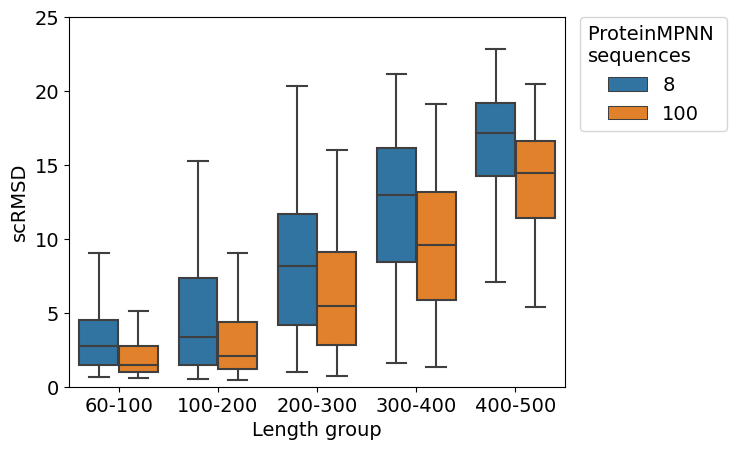

In [145]:
plot_sc_rmsd(self_conditioned_df, save_path='scrmsd_plot.png')

Percent designable: 0.6685393258426966
Percent designable: 0.5179775280898876


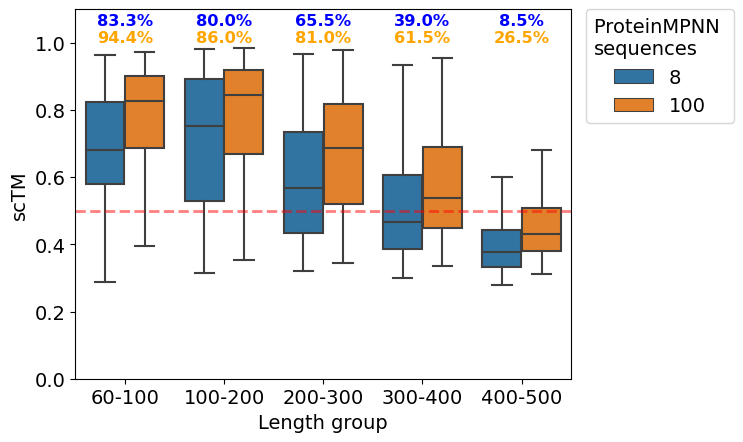

In [146]:
plot_sc_tm(self_conditioned_df, save_path='sctm_plot.png')

In [35]:
rmsd_samples, _ = process_pipeline(self_conditioned_df, metric='rmsd')

Percent designable: 0.6247191011235955
Percent designable: 0.4943820224719101


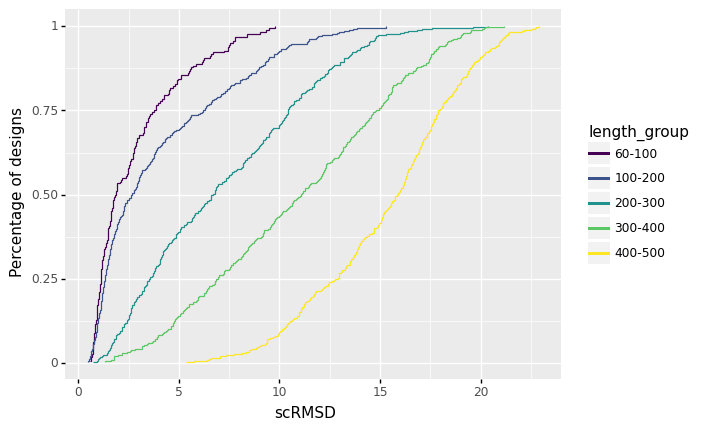

In [36]:
# Plot
p = (
    gg.ggplot(
        rmsd_samples,
        gg.aes('rmsd', color='length_group')
    )
    + gg.stats.stat_ecdf()
    # + gg.scales.scale_x_reverse()
    # + gg.geoms.geom_vline(
    #     xintercept=cutoff,
    #     size=1.0,
    #     linetype='dashed',
    #     color='red',
    # )
    + gg.labels.xlab('scRMSD')
    + gg.labels.ylab('Percentage of designs')
)

print(p)

# Compare with RFdiffusion

In [44]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_rfdiff_benchmark'
print(f'Reading samples from {results_dir}')
for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for i,sample_name in enumerate(os.listdir(length_dir)):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            design_csv['length'] = int(sample_length.split('_')[1])
            design_csv['sample_id'] = i
            all_csvs.append(design_csv)
benchmark_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_rfdiff_benchmark


In [47]:
# Format RF diffusion samples
s2f_df = pd.read_csv('S2F_data.csv')
s2f_df['Unconditional'] = s2f_df.problem.apply(lambda x: 'uncond' in x)
rfdiff_samples_df = s2f_df[s2f_df['Unconditional']]
metric = 'rmsd_af2_des'
df_temp = rfdiff_samples_df.sort_values(metric)
df_temp = df_temp.drop_duplicates('name')

cols = [
    'rmsd_af2_des',
    'problem',
    'random',
]
formatted_rf_diff = {
    'length': rfdiff_samples_df.problem.apply(lambda x: int(x.split('_')[1])),
    'rmsd': rfdiff_samples_df.rmsd_af2_des,
    'model': rfdiff_samples_df.random.map({
        'Outputs without Pre-Training': 'RFDiffusion w/o pretraining',
        'Outputs with Pre-Training': 'RFDiffusion',
    }),
}
formatted_rf_diff = pd.DataFrame(formatted_rf_diff)


/tmp/ipykernel_3548104/3773061146.py:2: DtypeWarning: Columns (98,118,119,121,122,127,133,134,135,139,140) have mixed types. Specify dtype option on import or set low_memory=False.


In [48]:
# Format FrameDiff samples
# rmsd_samples, _ = process_pipeline(refolded_df, metric='rmsd')
rmsd_samples, _ = process_pipeline(benchmark_df, metric='rmsd')
rmsd_seq_8_samples = rmsd_samples[rmsd_samples.Sequences == 100]
formatted_framediff = rmsd_seq_8_samples[['length', 'rmsd']]
formatted_framediff = formatted_framediff[formatted_framediff.length.isin([70, 100, 200, 300])]
formatted_framediff['model'] = 'FrameDiff'

Percent designable: 0.6927690001153269
Percent designable: 0.6828508822511821


In [52]:
formatted_framediff.length.value_counts()

70     2400
100    2400
200    2400
300    1471
Name: length, dtype: int64

In [49]:
formatted_df = pd.concat([formatted_rf_diff, formatted_framediff], axis=0)

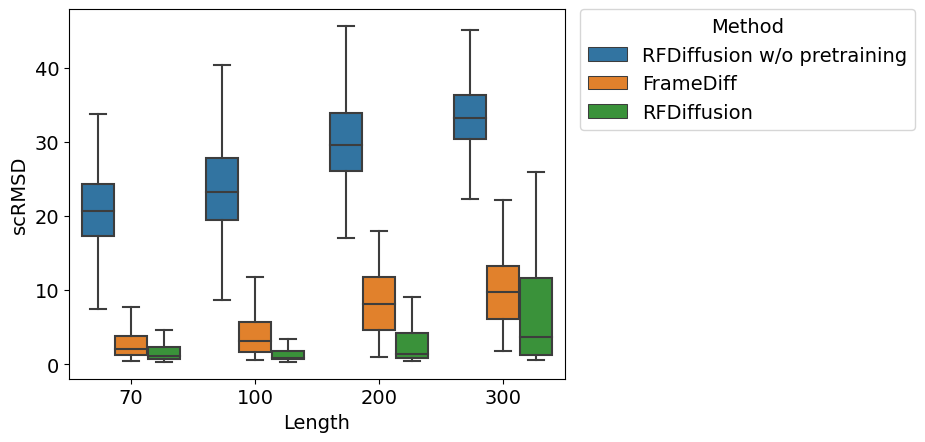

In [50]:
order = ['RFDiffusion w/o pretraining', 'FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = formatted_df,
    hue = 'model',
    hue_order=order,
    showfliers = False
)

# plt.ylim(0.0, 1.1)
plt.xlabel('Length')
plt.ylabel('scRMSD')
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
ax.legend_.set_title('Method')

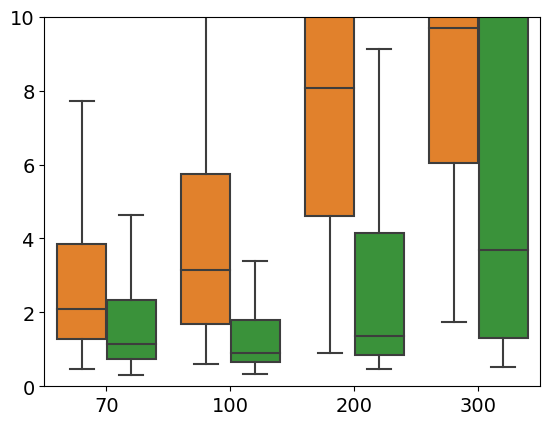

In [51]:
zoomed_df = formatted_df[formatted_df.model.isin(['FrameDiff', 'RFDiffusion'])]
order = ['FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = zoomed_df,
    hue = 'model',
    hue_order=order,
    showfliers = False,
    palette = ['#ff7f0e', '#2ca02c']
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0.0, 10)
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
legend.remove()